Device: cpu


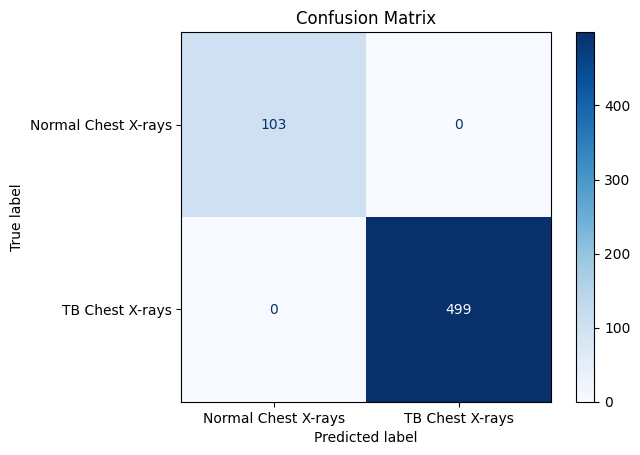


Classification Report:

                     precision    recall  f1-score   support

Normal Chest X-rays     1.0000    1.0000    1.0000       103
    TB Chest X-rays     1.0000    1.0000    1.0000       499

           accuracy                         1.0000       602
          macro avg     1.0000    1.0000    1.0000       602
       weighted avg     1.0000    1.0000    1.0000       602



In [2]:
import sys
import torch
import numpy as np
from pathlib import Path
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 🔹 Add src/ to path so model.py and utils.py can be imported
ROOT = Path("..").resolve()
sys.path.append(str(ROOT / "src"))

from model import get_model
from utils import load_checkpoint

# Paths
DATA = ROOT / "data"
SAVED = ROOT / "saved_models" / "best_model.pth"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Dataset (val set)
val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_ds = ImageFolder(root=str(DATA/"val"), transform=val_tf)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

# Load model
model = get_model(num_classes=len(val_ds.classes), pretrained=False)
model, classes = load_checkpoint(str(SAVED), model, device=device)
model.to(device).eval()

# Predictions
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_ds.classes)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=val_ds.classes, digits=4))
